# 3 Build a custom dataloader

In [1]:
import sys
sys.path.insert(0, "../..")

from src.data import data_tools, make_dataset
from pathlib import Path
import numpy as np
from typing import Iterator, Tuple, List
# NB: you might get a cuda warning if you don't have a GPU available.

/home/vscode/.cache/pypoetry/virtualenvs/deep-learning-jHmOY0S3-py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


The problem with images is that the size grows pretty fast.

In [2]:
image_size = (180, 180, 3)

for i in [1, 10, 100]:
    size = (i, ) + image_size
    X = np.zeros(size)
    size_byte = X.nbytes
    print(f"Size for {i} images: {size_byte / (2**20)} MB")

Size for 1 images: 0.7415771484375 MB
Size for 10 images: 7.415771484375 MB
Size for 100 images: 74.15771484375 MB


Imagine what would happen if you actually have a million images! And no, the answer to this
is not "just get more RAM in the cloud". You actually don't need to store everything at
the same time in memory, right? So we will use the dataloader pattern to fix this problem. 

Tensorflow has a nice [collection of datasets](https://www.tensorflow.org/datasets) for machine learning tasks. Let's download the 'flower_photos' dataset. We will use that dataset for image classification later on. 

In [3]:
data_dir = Path("../../data/raw").resolve()
data_dir.exists()

True

In [4]:
from src.data.make_dataset import DatasetFactoryProvider, DatasetType
flowersfactory = DatasetFactoryProvider.get_factory(DatasetType.FLOWERS)
# image_folder = make_dataset.get_flowers(data_dir)
flowersfactory.download_data()


2023-06-02 09:50:25.427 | INFO     | src.data.make_dataset:download_data:97 - Dataset already exists at /workspaces/ML22/data/raw/flowers


In [5]:
image_folder = flowersfactory.subfolder
print(image_folder)

/workspaces/ML22/data/raw/flowers


Let's  build a datagenerator from scratch; even though there are a lot of libraries (tensorflow, pytorch, trax) that provide datagenerators for images, it is a usefull practice to learn how the inside works. 

Eventually you will encounter a task were you will need to read in data from disk, and it is always usefull if you know how to adapt to a custom case. First step is to list all files in the directory:

In [6]:
def walk_dir(path: Path) -> Iterator:
    """loops recursively through a folder

    Args:
        path (Path): folder to loop trough. If a directory
            is encountered, loop through that recursively.

    Yields:
        Generator: all paths in a folder and subdirs.
    """

    for p in Path(path).iterdir():
        if p.is_dir():
            yield from walk_dir(p)
            continue
        # resolve works like .absolute(), but it removes the "../.." parts
        # of the location, so it is cleaner
        yield p.resolve()

Note that the first file is a .txt file, so we will need to filter that.

In [7]:
paths = walk_dir(image_folder)
file1 = next(paths)
file2 = next(paths)
file1, file2

(PosixPath('/workspaces/ML22/data/raw/flowers/flower_photos/LICENSE.txt'),
 PosixPath('/workspaces/ML22/data/raw/flowers/flower_photos/daisy/100080576_f52e8ee070_n.jpg'))

So, we now have a generator of paths in the directory. We can use a path to load an image from disk.
The stucture that is often used for storing images is to have subfolders that indicate a label. 
This is an easy way to create a dataset by a human (just drag and drop the images in the right folder to label them).

If the photo is inside the `tulips` subfolder, the class label should be `tulips`

In [8]:
from PIL import Image
file = next(paths)
img = Image.open(file)

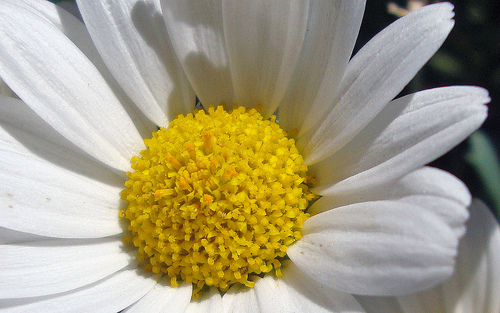

In [9]:
img.show()

The `iter_valid_paths` function pulls all files, strips the corrects suffixes (we only want images), retrieves the classnames by gathering the names of the subfolders, and returns both

In [10]:
from src.settings import FileTypes
def iter_valid_paths(path: Path, formats: List[FileTypes]) -> Tuple[Iterator, List[str]]:
    # gets all files in folder and subfolders
    walk = walk_dir(path)
    # retrieves foldernames as classnames
    class_names = [subdir.name for subdir in path.iterdir() if subdir.is_dir()]
    # keeps only specified formats
    formats_ = [f.value for f in formats]
    paths = (path for path in walk if path.suffix in formats_)
    return paths, class_names

In [11]:
formats = [FileTypes.JPG]
paths, class_names = iter_valid_paths(
    path = image_folder / "flower_photos", 
    formats=formats
)

In [12]:
next(paths), class_names

(PosixPath('/workspaces/ML22/data/raw/flowers/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

And, last, we need the `load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [13]:
imgpath = next(paths)
newsize = (150, 150)
img_ = Image.open(imgpath).resize(newsize, Image.LANCZOS)

In [14]:
img = np.asarray(img_)
img.shape

(150, 150, 3)

In [15]:
def load_image(
    path: Path, image_size: Tuple[int, int]
) -> np.ndarray:
    # load file
    img_ = Image.open(path).resize(image_size, Image.LANCZOS)
    return np.asarray(img_)

In [16]:
%timeit load_image(file, image_size=(180, 180))

8.72 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
file = next(paths)
img = load_image(file, (180, 180))
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

We need to add a batchsize. This is a single image, so batchsize=1. We can do that by adding tuples like this:

In [18]:
(1,) + img.shape

(1, 180, 180, 3)

In [19]:
x = np.reshape(img, (1,) + img.shape)
x.shape

(1, 180, 180, 3)

Lets have a look at the image we loaded

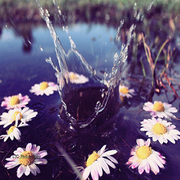

In [20]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

I implemented everything in the `src/data/data_tools.py` file, in a `Dataloader` class. Check out the file and study how I did that.

We can time this, and it is fast enough, considering we have a batchsize of 32; I clocked 2.68ms for a single image, so that would give us about 86ms for just the loading of the 32 images from disk. Depending on things like my cpu temperature, I get around 98ms for a batch. The additional 22ms for resizing, decoding and casting to numpy for 32 images comes down to about 0.7ms per image.

In [21]:
class ImgDataset(make_dataset.BaseDataset):
    def __init__(self, paths, class_names, img_size):
        self.img_size = img_size
        self.class_names = class_names
        super().__init__(paths)

    def process_data(self) -> None:
        for file in self.paths:
            img = load_image(file, self.img_size)
            x = np.reshape(img, (1,) + img.shape)
            y = self.class_names.index(file.parent.name)
            self.dataset.append((x, y))


In [22]:
from src.settings import FileTypes
paths, class_names = iter_valid_paths(
    path = image_folder / "flower_photos", 
    formats = [FileTypes.JPG],
)
dataset = ImgDataset([*paths], class_names, img_size=(150, 150))

All these methods are wrapped together inside the datasetfactory:

In [23]:
datasets = flowersfactory.create_dataset()
train = datasets["train"]

2023-06-02 09:51:04.259 | INFO     | src.data.make_dataset:download_data:97 - Dataset already exists at /workspaces/ML22/data/raw/flowers


In [24]:
len(train)

2936

In [25]:
x, y = train[1]
x.shape, y

((1, 224, 224, 3), 1)

the batch is now a pair of (img, label) tuples. However, we want to untangle a certain amount of them into a list of images and a list of labels.
Think of this as unzipping a zipper. Weirdly enough, in python we use the same command for this as we would use to create the pairs.

In [26]:
def batch_processor(batch):
    X, Y = zip(*batch)
    return np.concatenate(X), np.array(Y)

In [27]:
streamer = make_dataset.BaseDatastreamer(
    dataset=train,
    batchsize=32,
    preprocessor=batch_processor
)

In [28]:
gen = streamer.stream()
X, y = next(gen)
X.shape, y.shape

((32, 224, 224, 3), (32,))

Et voila; we loaded 32 (img, label) pairs from the disk, and our streamer has selected 32 of those pairs and recombined them into a batch of 32 images, sized 150x150, with 3 channels (for colour). The labels are just an array of 32 labels.

In [29]:
%timeit X, y = next(gen)

887 µs ± 90.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
streamers = flowersfactory.create_datastreamer(batchsize=32)

2023-06-02 09:51:41.123 | INFO     | src.data.make_dataset:download_data:97 - Dataset already exists at /workspaces/ML22/data/raw/flowers


In [31]:
streamers

{'train': ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 91),
 'valid': ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 22)}